In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/football-dataset/sample_submission.csv
/kaggle/input/football-dataset/X_test.csv
/kaggle/input/football-dataset/y_train.csv
/kaggle/input/football-dataset/X_train.csv


# **Importing required Libraries**

In [3]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# **Getting the data**

In [4]:
X_train_df = pd.read_csv("/kaggle/input/football-dataset/X_train.csv")
X_test_df = pd.read_csv("/kaggle/input/football-dataset/X_test.csv")
Y_train_df = pd.read_csv("/kaggle/input/football-dataset/y_train.csv")

In [5]:
print("X_train == input for train set")
X_train_df.head()

X_train == input for train set


,date,home_team,away_team,tournament,city,country,neutral
0,2001-03-11,Botswana,Mozambique,Friendly,Maseru,Lesotho,True
1,1982-06-22,Russia,Scotland,FIFA World Cup,Málaga,Spain,True
2,1987-07-27,São Tomé and Príncipe,Angola,Friendly,São Tomé,São Tomé and Príncipe,False
3,2011-09-02,Grenada,Belize,FIFA World Cup qualification,St. George's,Grenada,False
4,1998-11-18,Luxembourg,Belgium,Friendly,Luxembourg,Luxembourg,False


In [6]:
print("X_test = input for test set")
X_test_df.head()

X_test = input for test set


,date,home_team,away_team,tournament,city,country,neutral
0,2023-09-06,Macau,Bhutan,Friendly,Taipa,Macau,False
1,1966-08-13,Malaysia,Vietnam Republic,Merdeka Tournament,Kuala Lumpur,Malaysia,False
2,1951-09-02,Suriname,Guyana,Friendly,Paramaribo,Suriname,False
3,2012-08-22,India,Syria,Nehru Cup,New Delhi,India,False
4,1973-12-15,Thailand,Myanmar,King's Cup,Bangkok,Thailand,False


In [7]:
print("Y_train = output for train set")
Y_train_df.head()

Y_train = output for train set


,result
0,1
1,0
2,0
3,1
4,0


**Lets look closer into out training set and test set**

In [8]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41660 entries, 0 to 41659
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        41660 non-null  object
 1   home_team   41660 non-null  object
 2   away_team   41660 non-null  object
 3   tournament  41660 non-null  object
 4   city        41660 non-null  object
 5   country     41660 non-null  object
 6   neutral     41660 non-null  bool  
dtypes: bool(1), object(6)
memory usage: 1.9+ MB


In [9]:
Y_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41660 entries, 0 to 41659
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   result  41660 non-null  int64
dtypes: int64(1)
memory usage: 325.6 KB


In [10]:
for column in X_train_df.columns:
    num_unique_values = X_train_df[column].nunique()
    print(f"Column '{column}' has {num_unique_values} unique values")

Column 'date' has 15184 unique values
Column 'home_team' has 327 unique values
Column 'away_team' has 320 unique values
Column 'tournament' has 161 unique values
Column 'city' has 2014 unique values
Column 'country' has 271 unique values
Column 'neutral' has 2 unique values


In [11]:
# Assuming df is your Pandas DataFrame containing the dataset
home_teams = set(X_train_df['home_team'].unique())
away_teams = set(X_train_df['away_team'].unique())

# Find common teams
common_teams = home_teams.intersection(away_teams)

# Print the number of common teams
num_common_teams = len(common_teams)
print("Number of common teams:", num_common_teams)


Number of common teams: 311


In [12]:
# Merged DataFrame
merged_df = X_train_df.join(Y_train_df)

# Display the merged DataFrame
merged_df.head()

,date,home_team,away_team,tournament,city,country,neutral,result
0,2001-03-11,Botswana,Mozambique,Friendly,Maseru,Lesotho,True,1
1,1982-06-22,Russia,Scotland,FIFA World Cup,Málaga,Spain,True,0
2,1987-07-27,São Tomé and Príncipe,Angola,Friendly,São Tomé,São Tomé and Príncipe,False,0
3,2011-09-02,Grenada,Belize,FIFA World Cup qualification,St. George's,Grenada,False,1
4,1998-11-18,Luxembourg,Belgium,Friendly,Luxembourg,Luxembourg,False,0


In [13]:
def calculate_team_statistics(matches_df):
    # Create an empty list to store team statistics DataFrames
    team_statistics_dfs = []

    # Get unique teams
    unique_teams = set(matches_df['home_team'].unique()).union(set(matches_df['away_team'].unique()))
    
    # Iterate over unique teams
    for team in unique_teams:
        # Filter matches where the team played as either home or away
        team_matches = matches_df[(matches_df['home_team'] == team) | (matches_df['away_team'] == team)]

        # Total number of games played
        total_games = len(team_matches)

        # Number of wins
        wins = len(team_matches[team_matches['result'] == 2])

        # Number of losses
        losses = len(team_matches[team_matches['result'] == 1])

        # Number of wins when neutral is false
        wins_neutral_false = len(team_matches[(team_matches['result'] == 2) & (team_matches['neutral'] == False)])

        # Append team statistics to list
        team_statistics_dfs.append(pd.DataFrame({
            'Team': [team],
            'Total Games': [total_games],
            'Wins': [wins],
            'Losses': [losses],
            'Wins (Neutral False)': [wins_neutral_false]
        }))

    # Concatenate all team statistics DataFrames
    team_statistics_df = pd.concat(team_statistics_dfs, ignore_index=True)
    
    # Set index to the team names
    team_statistics_df.set_index('Team', inplace=True)
    
    return team_statistics_df

# Call the function with X_train_df to get the DataFrame with team statistics
team_statistics_df = calculate_team_statistics(merged_df)

# Display the DataFrame
(team_statistics_df).head()


,Total Games,Wins,Losses,Wins (Neutral False)
Team,,,,
Austria,742,353,233,333
Rwanda,227,110,55,83
United Arab Emirates,512,253,138,174
Suriname,345,177,90,146
Panama,442,223,108,174


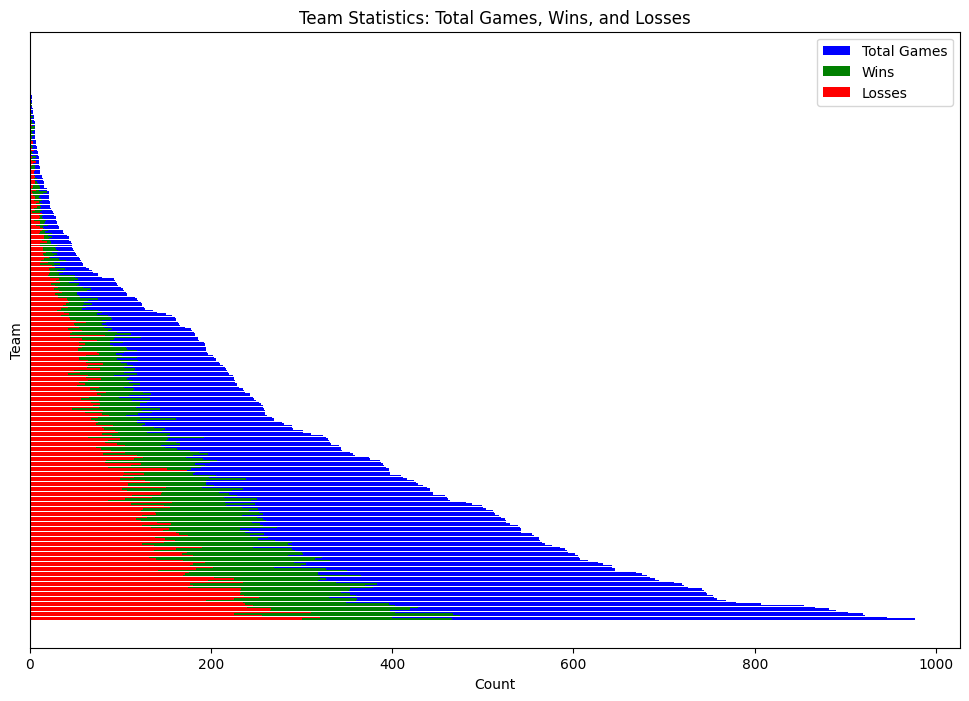

In [55]:
import matplotlib.pyplot as plt

# Sort the team statistics DataFrame by total games in descending order
team_statistics_df_sorted = team_statistics_df.sort_values(by='Total Games', ascending=False)

# Plot the graph
plt.figure(figsize=(12, 8))
plt.barh(range(len(team_statistics_df_sorted)), team_statistics_df_sorted['Total Games'], color='blue', label='Total Games')
plt.barh(range(len(team_statistics_df_sorted)), team_statistics_df_sorted['Wins'], color='green', label='Wins')
plt.barh(range(len(team_statistics_df_sorted)), team_statistics_df_sorted['Losses'], color='red', label='Losses')

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Team')
plt.title('Team Statistics: Total Games, Wins, and Losses')
plt.legend()

# Hide y-axis ticks and labels
plt.yticks([])

# Show plot
plt.show()


In [34]:
# # Function to calculate win and loss percentages
# def calculate_percentages(total_games, wins, losses):
#     win_percentage = wins / total_games if total_games != 0 else 0
#     loss_percentage = losses / total_games if total_games != 0 else 0
#     return win_percentage, loss_percentage

# # Function to create dictionary from team_statistics_df
# def create_team_stats_dict(team_stats_df):
#     team_stats_dict = {}
#     for team, stats in team_stats_df.iterrows():
#         team_stats_dict[team] = {
#             'Total Games': stats['Total Games'],
#             'Wins': stats['Wins'],
#             'Losses': stats['Losses'],
#             'Wins (Neutral False)': stats['Wins (Neutral False)']
#         }
#     return team_stats_dict

# # Create dictionary from team_statistics_df
# team_stats_dict = create_team_stats_dict(team_statistics_df)

# # Initialize lists to store data
# home_team_total_games = []
# home_team_win_percentage = []
# home_team_loss_percentage = []
# away_team_total_games = []
# away_team_win_percentage = []
# away_team_loss_percentage = []
# neutral_list = []

# # Iterate over each row in X_train_df
# for index, row in X_train_df.iterrows():
#     home_team = row['home_team']
#     away_team = row['away_team']
#     neutral = 1 if row['neutral'] else 0
    
#     # Get home team statistics from dictionary
#     home_team_stats = team_stats_dict.get(home_team, {})
#     home_team_total_games.append(home_team_stats.get('Total Games', 0))
#     home_team_wins = home_team_stats.get('Wins', 0)
#     home_team_losses = home_team_stats.get('Losses', 0)
#     home_win_percentage, home_loss_percentage = calculate_percentages(home_team_stats.get('Total Games', 0), home_team_wins, home_team_losses)
#     home_team_win_percentage.append(home_win_percentage)
#     home_team_loss_percentage.append(home_loss_percentage)
    
#     # Get away team statistics from dictionary
#     away_team_stats = team_stats_dict.get(away_team, {})
#     away_team_total_games.append(away_team_stats.get('Total Games', 0))
#     away_team_wins = away_team_stats.get('Wins', 0)
#     away_team_losses = away_team_stats.get('Losses', 0)
#     away_win_percentage, away_loss_percentage = calculate_percentages(away_team_stats.get('Total Games', 0), away_team_wins, away_team_losses)
#     away_team_win_percentage.append(away_win_percentage)
#     away_team_loss_percentage.append(away_loss_percentage)
    
#     neutral_list.append(neutral)

# # Create X_train_input_df DataFrame
# X_train_input_df = pd.DataFrame({
#     'home_team_total_games': home_team_total_games,
#     'home_team_win_percentage': home_team_win_percentage,
#     'home_team_loss_percentage': home_team_loss_percentage,
#     'away_team_total_games': away_team_total_games,
#     'away_team_win_percentage': away_team_win_percentage,
#     'away_team_loss_percentage': away_team_loss_percentage,
#     'neutral': neutral_list
# })

# # Display the DataFrame
# (X_train_input_df).head()


,home_team_total_games,home_team_win_percentage,home_team_loss_percentage,away_team_total_games,away_team_win_percentage,away_team_loss_percentage,neutral
0,278,0.428058,0.273381,311,0.498392,0.257235,1
1,643,0.419907,0.314152,744,0.473118,0.311828,1
2,56,0.571429,0.285714,343,0.434402,0.212828,0
3,209,0.483254,0.296651,98,0.530612,0.285714,0
4,397,0.428212,0.438287,747,0.473896,0.310576,0


In [73]:
## adding more columns to input data
# Function to calculate win and loss percentages
def calculate_percentages(total_games, wins, losses):
    win_percentage = wins / total_games if total_games != 0 else 0
    loss_percentage = losses / total_games if total_games != 0 else 0
    return win_percentage, loss_percentage

# Function to create dictionary from team_statistics_df
def create_team_stats_dict(team_stats_df):
    team_stats_dict = {}
    for team, stats in team_stats_df.iterrows():
        team_stats_dict[team] = {
            'Total Games': stats['Total Games'],
            'Wins': stats['Wins'],
            'Losses': stats['Losses'],
            'Wins (Neutral False)': stats['Wins (Neutral False)']
        }
    return team_stats_dict

# Create dictionary from team_statistics_df
team_stats_dict = create_team_stats_dict(team_statistics_df)

# Initialize lists to store data
home_team_total_games = []
home_team_win_percentage = []
home_team_loss_percentage = []
away_team_total_games = []
away_team_win_percentage = []
away_team_loss_percentage = []
neutral_list = []
win_list = []
loss_list = []

# Iterate over each row in X_train_df
for index, row in X_train_df.iterrows():
    home_team = row['home_team']
    away_team = row['away_team']
    neutral = 1 if row['neutral'] else 0
    
    # Get home team statistics from dictionary
    home_team_stats = team_stats_dict.get(home_team, {})
    home_team_total_games.append(home_team_stats.get('Total Games', 0))
    home_team_wins = home_team_stats.get('Wins', 0)
    home_team_losses = home_team_stats.get('Losses', 0)
    home_win_percentage, home_loss_percentage = calculate_percentages(home_team_stats.get('Total Games', 0), home_team_wins, home_team_losses)
    home_team_win_percentage.append(home_win_percentage)
    home_team_loss_percentage.append(home_loss_percentage)
    
    # Get away team statistics from dictionary
    away_team_stats = team_stats_dict.get(away_team, {})
    away_team_total_games.append(away_team_stats.get('Total Games', 0))
    away_team_wins = away_team_stats.get('Wins', 0)
    away_team_losses = away_team_stats.get('Losses', 0)
    away_win_percentage, away_loss_percentage = calculate_percentages(away_team_stats.get('Total Games', 0), away_team_wins, away_team_losses)
    away_team_win_percentage.append(away_win_percentage)
    away_team_loss_percentage.append(away_loss_percentage)
    
    neutral_list.append(neutral)
    win_list.append(home_team_wins + away_team_wins)
    loss_list.append(home_team_losses + away_team_losses)

# Create X_train_input_df DataFrame
X_train_input_df = pd.DataFrame({
    'home_team_total_games': home_team_total_games,
    'home_team_win_percentage': home_team_win_percentage,
    'home_team_loss_percentage': home_team_loss_percentage,
    'away_team_total_games': away_team_total_games,
    'away_team_win_percentage': away_team_win_percentage,
    'away_team_loss_percentage': away_team_loss_percentage,
    'neutral': neutral_list,
    'win': win_list,
    'loss': loss_list,
    'total_played': [games + losses for games, losses in zip(home_team_total_games, away_team_total_games)]
})

# Display the DataFrame
X_train_input_df.head()


,home_team_total_games,home_team_win_percentage,home_team_loss_percentage,away_team_total_games,away_team_win_percentage,away_team_loss_percentage,neutral,win,loss,total_played
0,278,0.428058,0.273381,311,0.498392,0.257235,1,274,156,589
1,643,0.419907,0.314152,744,0.473118,0.311828,1,622,434,1387
2,56,0.571429,0.285714,343,0.434402,0.212828,0,181,89,399
3,209,0.483254,0.296651,98,0.530612,0.285714,0,153,90,307
4,397,0.428212,0.438287,747,0.473896,0.310576,0,524,406,1144


In [74]:
## DROPING COLUMNS away_team_loss_percentange,home_team_loss_percentage,loss
X_train_input_df.drop(columns=['away_team_loss_percentage', 'home_team_loss_percentage', 'loss'], inplace=True)
X_train_input_df.head()

,home_team_total_games,home_team_win_percentage,away_team_total_games,away_team_win_percentage,neutral,win,total_played
0,278,0.428058,311,0.498392,1,274,589
1,643,0.419907,744,0.473118,1,622,1387
2,56,0.571429,343,0.434402,0,181,399
3,209,0.483254,98,0.530612,0,153,307
4,397,0.428212,747,0.473896,0,524,1144


In [38]:
X_train_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41660 entries, 0 to 41659
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   home_team_total_games      41660 non-null  int64  
 1   home_team_win_percentage   41660 non-null  float64
 2   home_team_loss_percentage  41660 non-null  float64
 3   away_team_total_games      41660 non-null  int64  
 4   away_team_win_percentage   41660 non-null  float64
 5   away_team_loss_percentage  41660 non-null  float64
 6   neutral                    41660 non-null  int64  
 7   win                        41660 non-null  int64  
 8   loss                       41660 non-null  int64  
 9   total_played               41660 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 3.2 MB


In [39]:
print("X_train_df : ",X_train_df.shape[0])
print("Y_train_df : ",Y_train_df.shape[0])

X_train_df :  41660
Y_train_df :  41660


In [75]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Assuming X_train_input_df contains the input data
# Assuming y_train_df contains the output labels
Y_train_df = pd.DataFrame(Y_train_df)
# Reshape y_train_df
Y_train_df = Y_train_df.values.ravel()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_input_df, Y_train_df, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.536365818530965
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1967
           1       0.49      0.40      0.44      2321
           2       0.55      0.87      0.68      4044

    accuracy                           0.54      8332
   macro avg       0.35      0.43      0.37      8332
weighted avg       0.40      0.54      0.45      8332



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


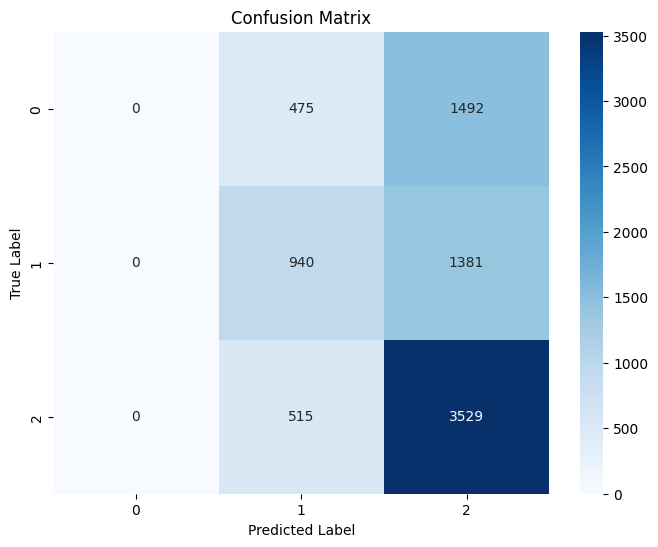

In [76]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1', '2'], yticklabels=['0', '1', '2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## **Playing with different models**

In [53]:
## Playing with different models

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_input_df, Y_train_df, test_size=0.2, random_state=42)

# Initialize models
models = {
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {accuracy}")
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))


Training Random Forest...
Accuracy for Random Forest: 0.5230436869899184
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.28      0.18      0.22      1967
           1       0.48      0.48      0.48      2321
           2       0.61      0.71      0.66      4044

    accuracy                           0.52      8332
   macro avg       0.46      0.46      0.45      8332
weighted avg       0.50      0.52      0.51      8332

Training Support Vector Machine...
Accuracy for Support Vector Machine: 0.5306048967834853
Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1967
           1       0.52      0.33      0.40      2321
           2       0.53      0.90      0.67      4044

    accuracy                           0.53      8332
   macro avg       0.35      0.41      0.36      8332
weighted avg       0.40      0.53     

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy for K-Nearest Neighbors: 0.4867978876620259
Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.27      0.27      0.27      1967
           1       0.44      0.46      0.45      2321
           2       0.62      0.61      0.61      4044

    accuracy                           0.49      8332
   macro avg       0.44      0.45      0.45      8332
weighted avg       0.49      0.49      0.49      8332



In [29]:
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# # Define the ANN model
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(7,)),
#     Dense(64, activation='relu'),
#     Dense(3, activation='softmax')
# ])

# # Compile the model
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# # Train the model
# model.fit(X_train_df.values, Y_train_df.values, epochs=10, batch_size=32)

# # Evaluate the model
# loss, accuracy = model.evaluate(X_train_df.values, Y_train_df.values)
# print("Accuracy:", accuracy)

# # Make predictions
# predictions = model.predict(X_train_df.values)

# # Get the index of the maximum value for each prediction
# predicted_labels = tf.argmax(predictions, axis=1).numpy()


# **Getting back to Artificial Neural Networks**


The ANN model predicts the probabilities of 0,1,2 and returns a vector of size 3 (eg : [0.25,0.54,0.13]),so we have to modify the y_test values from [1,0,2,1,1....] to [[0,1,0],[1,0,0],...]

In [43]:
encoded_labels = []

# Loop through each value in Y_train_df
for label in Y_train_df:
    # Create a one-hot encoded array based on the label value
    if label == 0:
        encoded_labels.append([1, 0, 0])
    elif label == 1:
        encoded_labels.append([0, 1, 0])
    elif label == 2:
        encoded_labels.append([0, 0, 1])
Y_train_ANN = pd.DataFrame(encoded_labels)

In [44]:
print(Y_train_ANN)

       0  1  2
0      0  1  0
1      1  0  0
2      1  0  0
3      0  1  0
4      1  0  0
...   .. .. ..
41655  0  1  0
41656  0  1  0
41657  0  0  1
41658  0  0  1
41659  1  0  0

[41660 rows x 3 columns]


In [125]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

# Assuming X_train_input_df and Y_train_ANN are already defined

# Convert input and output dataframes to numpy arrays
X_train = X_train_input_df.values
Y_train = Y_train_ANN.values

# Scale the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Define the number of input features and output classes
input_dim = X_train_scaled.shape[1]
output_dim = Y_train.shape[1]

# Split the data into training and validation sets
X_train_split, X_val, Y_train_split, Y_val = train_test_split(X_train_scaled, Y_train, test_size=0.2, random_state=42)

# Create the model
model = Sequential()
model.add(Dense(32, input_dim=input_dim, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(output_dim, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train_split, Y_train_split, epochs=25, batch_size=32, validation_data=(X_val, Y_val))


Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1042/1042 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5245 - loss: 0.9962 - val_accuracy: 0.5325 - val_loss: 0.9849
Epoch 2/25
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5352 - loss: 0.9817 - val_accuracy: 0.5368 - val_loss: 0.9855
Epoch 3/25
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5365 - loss: 0.9818 - val_accuracy: 0.5256 - val_loss: 0.9874
Epoch 4/25
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5379 - loss: 0.9785 - val_accuracy: 0.5382 - val_loss: 0.9761
Epoch 5/25
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5340 - loss: 0.9835 - val_accuracy: 0.5383 - val_loss: 0.9792
Epoch 6/25
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5427 - loss: 0.9762 - val_accuracy: 0.5355 - val_loss: 0.9786
Epoch 7/25
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5399 - loss: 0.9752 - val_accuracy: 0.5356 - val_loss: 0.9805
Epoch 8/25
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.5393 - loss: 0.9769 - val_accurac

In [126]:
loss, accuracy = model.evaluate(X_val, Y_val)
print("Validation Accuracy:", accuracy)

261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5443 - loss: 0.9712
Validation Accuracy: 0.5427268147468567


# **Getting predictions for submission**

In [120]:
## adding more columns to input data
# Function to calculate win and loss percentages
def calculate_percentages(total_games, wins, losses):
    win_percentage = wins / total_games if total_games != 0 else 0
    loss_percentage = losses / total_games if total_games != 0 else 0
    return win_percentage, loss_percentage

# Function to create dictionary from team_statistics_df
def create_team_stats_dict(team_stats_df):
    team_stats_dict = {}
    for team, stats in team_stats_df.iterrows():
        team_stats_dict[team] = {
            'Total Games': stats['Total Games'],
            'Wins': stats['Wins'],
            'Losses': stats['Losses'],
            'Wins (Neutral False)': stats['Wins (Neutral False)']
        }
    return team_stats_dict

# Create dictionary from team_statistics_df
team_stats_dict = create_team_stats_dict(team_statistics_df)

# Initialize lists to store data
home_team_total_games = []
home_team_win_percentage = []
home_team_loss_percentage = []
away_team_total_games = []
away_team_win_percentage = []
away_team_loss_percentage = []
neutral_list = []
win_list = []
loss_list = []

# Iterate over each row in X_train_df
for index, row in X_test_df.iterrows():  # 1.CHANGE X_test_df in X_test_df.iterrows() with new dataset name (it should be in pd.dataframe)
    home_team = row['home_team']
    away_team = row['away_team']
    neutral = 1 if row['neutral'] else 0
    
    # Get home team statistics from dictionary
    home_team_stats = team_stats_dict.get(home_team, {})
    home_team_total_games.append(home_team_stats.get('Total Games', 0))
    home_team_wins = home_team_stats.get('Wins', 0)
    home_team_losses = home_team_stats.get('Losses', 0)
    home_win_percentage, home_loss_percentage = calculate_percentages(home_team_stats.get('Total Games', 0), home_team_wins, home_team_losses)
    home_team_win_percentage.append(home_win_percentage)
    home_team_loss_percentage.append(home_loss_percentage)
    
    # Get away team statistics from dictionary
    away_team_stats = team_stats_dict.get(away_team, {})
    away_team_total_games.append(away_team_stats.get('Total Games', 0))
    away_team_wins = away_team_stats.get('Wins', 0)
    away_team_losses = away_team_stats.get('Losses', 0)
    away_win_percentage, away_loss_percentage = calculate_percentages(away_team_stats.get('Total Games', 0), away_team_wins, away_team_losses)
    away_team_win_percentage.append(away_win_percentage)
    away_team_loss_percentage.append(away_loss_percentage)
    
    neutral_list.append(neutral)
    win_list.append(home_team_wins + away_team_wins)
    loss_list.append(home_team_losses + away_team_losses)

# Create X_train_input_df DataFrame
X_test_input_df = pd.DataFrame({   # 2.change here
    'home_team_total_games': home_team_total_games,
    'home_team_win_percentage': home_team_win_percentage,
    'home_team_loss_percentage': home_team_loss_percentage,
    'away_team_total_games': away_team_total_games,
    'away_team_win_percentage': away_team_win_percentage,
    'away_team_loss_percentage': away_team_loss_percentage,
    'neutral': neutral_list,
    'win': win_list,
    'loss': loss_list,
    'total_played': [games + losses for games, losses in zip(home_team_total_games, away_team_total_games)]
})

# Display the DataFrame
X_test_input_df.head()  # 3.change here


,home_team_total_games,home_team_win_percentage,home_team_loss_percentage,away_team_total_games,away_team_win_percentage,away_team_loss_percentage,neutral,win,loss,total_played
0,124,0.556452,0.322581,75,0.666667,0.266667,0,119,60,199
1,722,0.512465,0.249307,172,0.476744,0.319767,0,452,235,894
2,345,0.513043,0.260870,255,0.478431,0.305882,0,299,168,600
3,438,0.433790,0.344749,412,0.480583,0.279126,0,388,266,850
4,726,0.522039,0.241047,416,0.574519,0.240385,0,618,275,1142


In [121]:
## DROPING COLUMNS away_team_loss_percentange,home_team_loss_percentage,loss
X_test_input_df.drop(columns=['away_team_loss_percentage', 'home_team_loss_percentage', 'loss'], inplace=True) # 4.change here
X_test_input_df.head()# 5.change here

,home_team_total_games,home_team_win_percentage,away_team_total_games,away_team_win_percentage,neutral,win,total_played
0,124,0.556452,75,0.666667,0,119,199
1,722,0.512465,172,0.476744,0,452,894
2,345,0.513043,255,0.478431,0,299,600
3,438,0.433790,412,0.480583,0,388,850
4,726,0.522039,416,0.574519,0,618,1142


In [128]:
predicted_values = model.predict(X_test_input_df) # 6.change here

# Convert the predicted values to categories (0, 1, or 2)
predicted_categories = np.argmax(predicted_values, axis=1)

# Display the predicted categories
print(predicted_categories)

145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[2 2 2 ... 1 2 2]


In [123]:
# for index, predicted_category in enumerate(predicted_categories):
#     print(f"Index: {index}, Predicted Category: {predicted_category}")

In [132]:
# Create a DataFrame with index and predicted categories
predicted_df = pd.DataFrame({
    'row_id': range(len(predicted_categories)),
    'result': predicted_categories
})

# Save the DataFrame to a CSV file
predicted_df.to_csv('predicted_values_final_result.csv', index=False)